# CSAF F16 Example

This notebook illustrates how to run CSAF on a model of the F16. Each system in CSAF is comprised of a set of components containing dynamics. 

## CSAF Messages


Before we can create components, we need to define the message formats that a component uses to communicate over. In this example, we'll look at the messages used by the F16 aircraft plant. We use a namedtuple to specify the length, type, and identifiers of each element of a signal. This can be used to specify signal variables inside of CSAF, or type check code using tools such as `mypy`. 

In [1]:
from typing import NamedTuple


class F16PlantStateMessage(NamedTuple):
    """example message describing the state of the F16 plant"""
    vt: float
    alpha: float
    beta: float
    phi: float
    theta: float
    psi: float
    p: float
    q: float
    r: float
    pn: float
    pe: float
    h: float
    pow: float

## CSAF Components

Once we have out messages defined, we can create components. Components have well defined message interfaces--inputs, outputs, and states. They also have model parameters that can be used to adjust a model available in the `flows` field. These parameters, as well as inputs and states, require default values specified in the `default_initial_values` and `default_parameters` fields.

In [2]:
import csaf
import csaf_f16.messages as f16mesg
import csaf_f16.models.llc as llc


class F16LlcComponent(csaf.ContinuousComponent):
    """Example Component Description in CSAF
    
    F16 Low Level Controller
    """
    
    # verbose name for the system
    name = "F16 Low Level Controller"
    
    # sampling frequency of system 
    sampling_frequency = 30.0
    
    # model parameters (will be constant during simulation)
    default_parameters = {
        "lqr_name": "lqr_original",
        "throttle_max": 1,
        "throttle_min": 0,
        "elevator_max": 25,
        "elevator_min": -25,
        "aileron_max": 21.5,
        "aileron_min": -21.5,
        "rudder_max": 30.0,
        "rudder_min": -30.0
    }
    
    # component inputs (messages)
    inputs = (
        ("inputs_pstates", f16mesg.F16PlantStateMessage),
        ("inputs_poutputs", f16mesg.F16PlantOutputMessage),
        ("inputs_coutputs", f16mesg.F16ControllerOutputMessage)
    )
    
    # component outputs (messages)
    outputs = (
        ("outputs", f16mesg.F16ControllerOutputMessage),
    )
    
    # component states (single message)
    states = f16mesg.F16LlcStateMessage
    
    # default values for input and state buffer
    default_initial_values = {
        "states": [0.0, 0.0, 0.0],
        "inputs_pstates": [0.0,]*13,
        "inputs_poutputs": [0.0, 0.0, 0.0, 0.0],
        "inputs_coutputs": [0.0, 0.0, 0.0, 0.0]
    }
    
    # flows map inputs and state to updated state and output
    # these functions implement the dynamics
    flows = {
        "outputs": llc.model_output,
        "states": llc.model_state_update
    }
    
    # function to initialize the system 
    # used to translate the parameters to object instances
    initialize = llc.model_init

## CSAF Systems

From collection of components, we can build a full control system. We create identifiers in the `components` field and define component connections in `connections`.

In [3]:
import csaf_f16.components as f16c


class F16Simple(csaf.System):
    """Example System Description in CSAF
    
    
    Simple F16 Aircraft (Low Level Controller + Autopilot)
    """
    components = {
        "plant": f16c.F16PlantComponent,
        "llc": f16c.F16NNLlcComponent,
        "autopilot": f16c.F16GcasComponent
    }

    connections = {
        ("llc", "inputs_pstates"): ("plant", "states"),
        ("llc", "inputs_poutputs"): ("plant", "outputs"),
        ("llc", "inputs_coutputs"): ("autopilot", "outputs"),
        ("plant", "inputs"): ("llc", "outputs"),
        ("autopilot", "inputs_poutputs"): ("plant", "outputs"),
        ("autopilot", "inputs_pstates"): ("plant", "states")
    }

## Loading the configuration

In [4]:
from csaf_f16.systems import F16Shield
import csaf.utils as csafutils

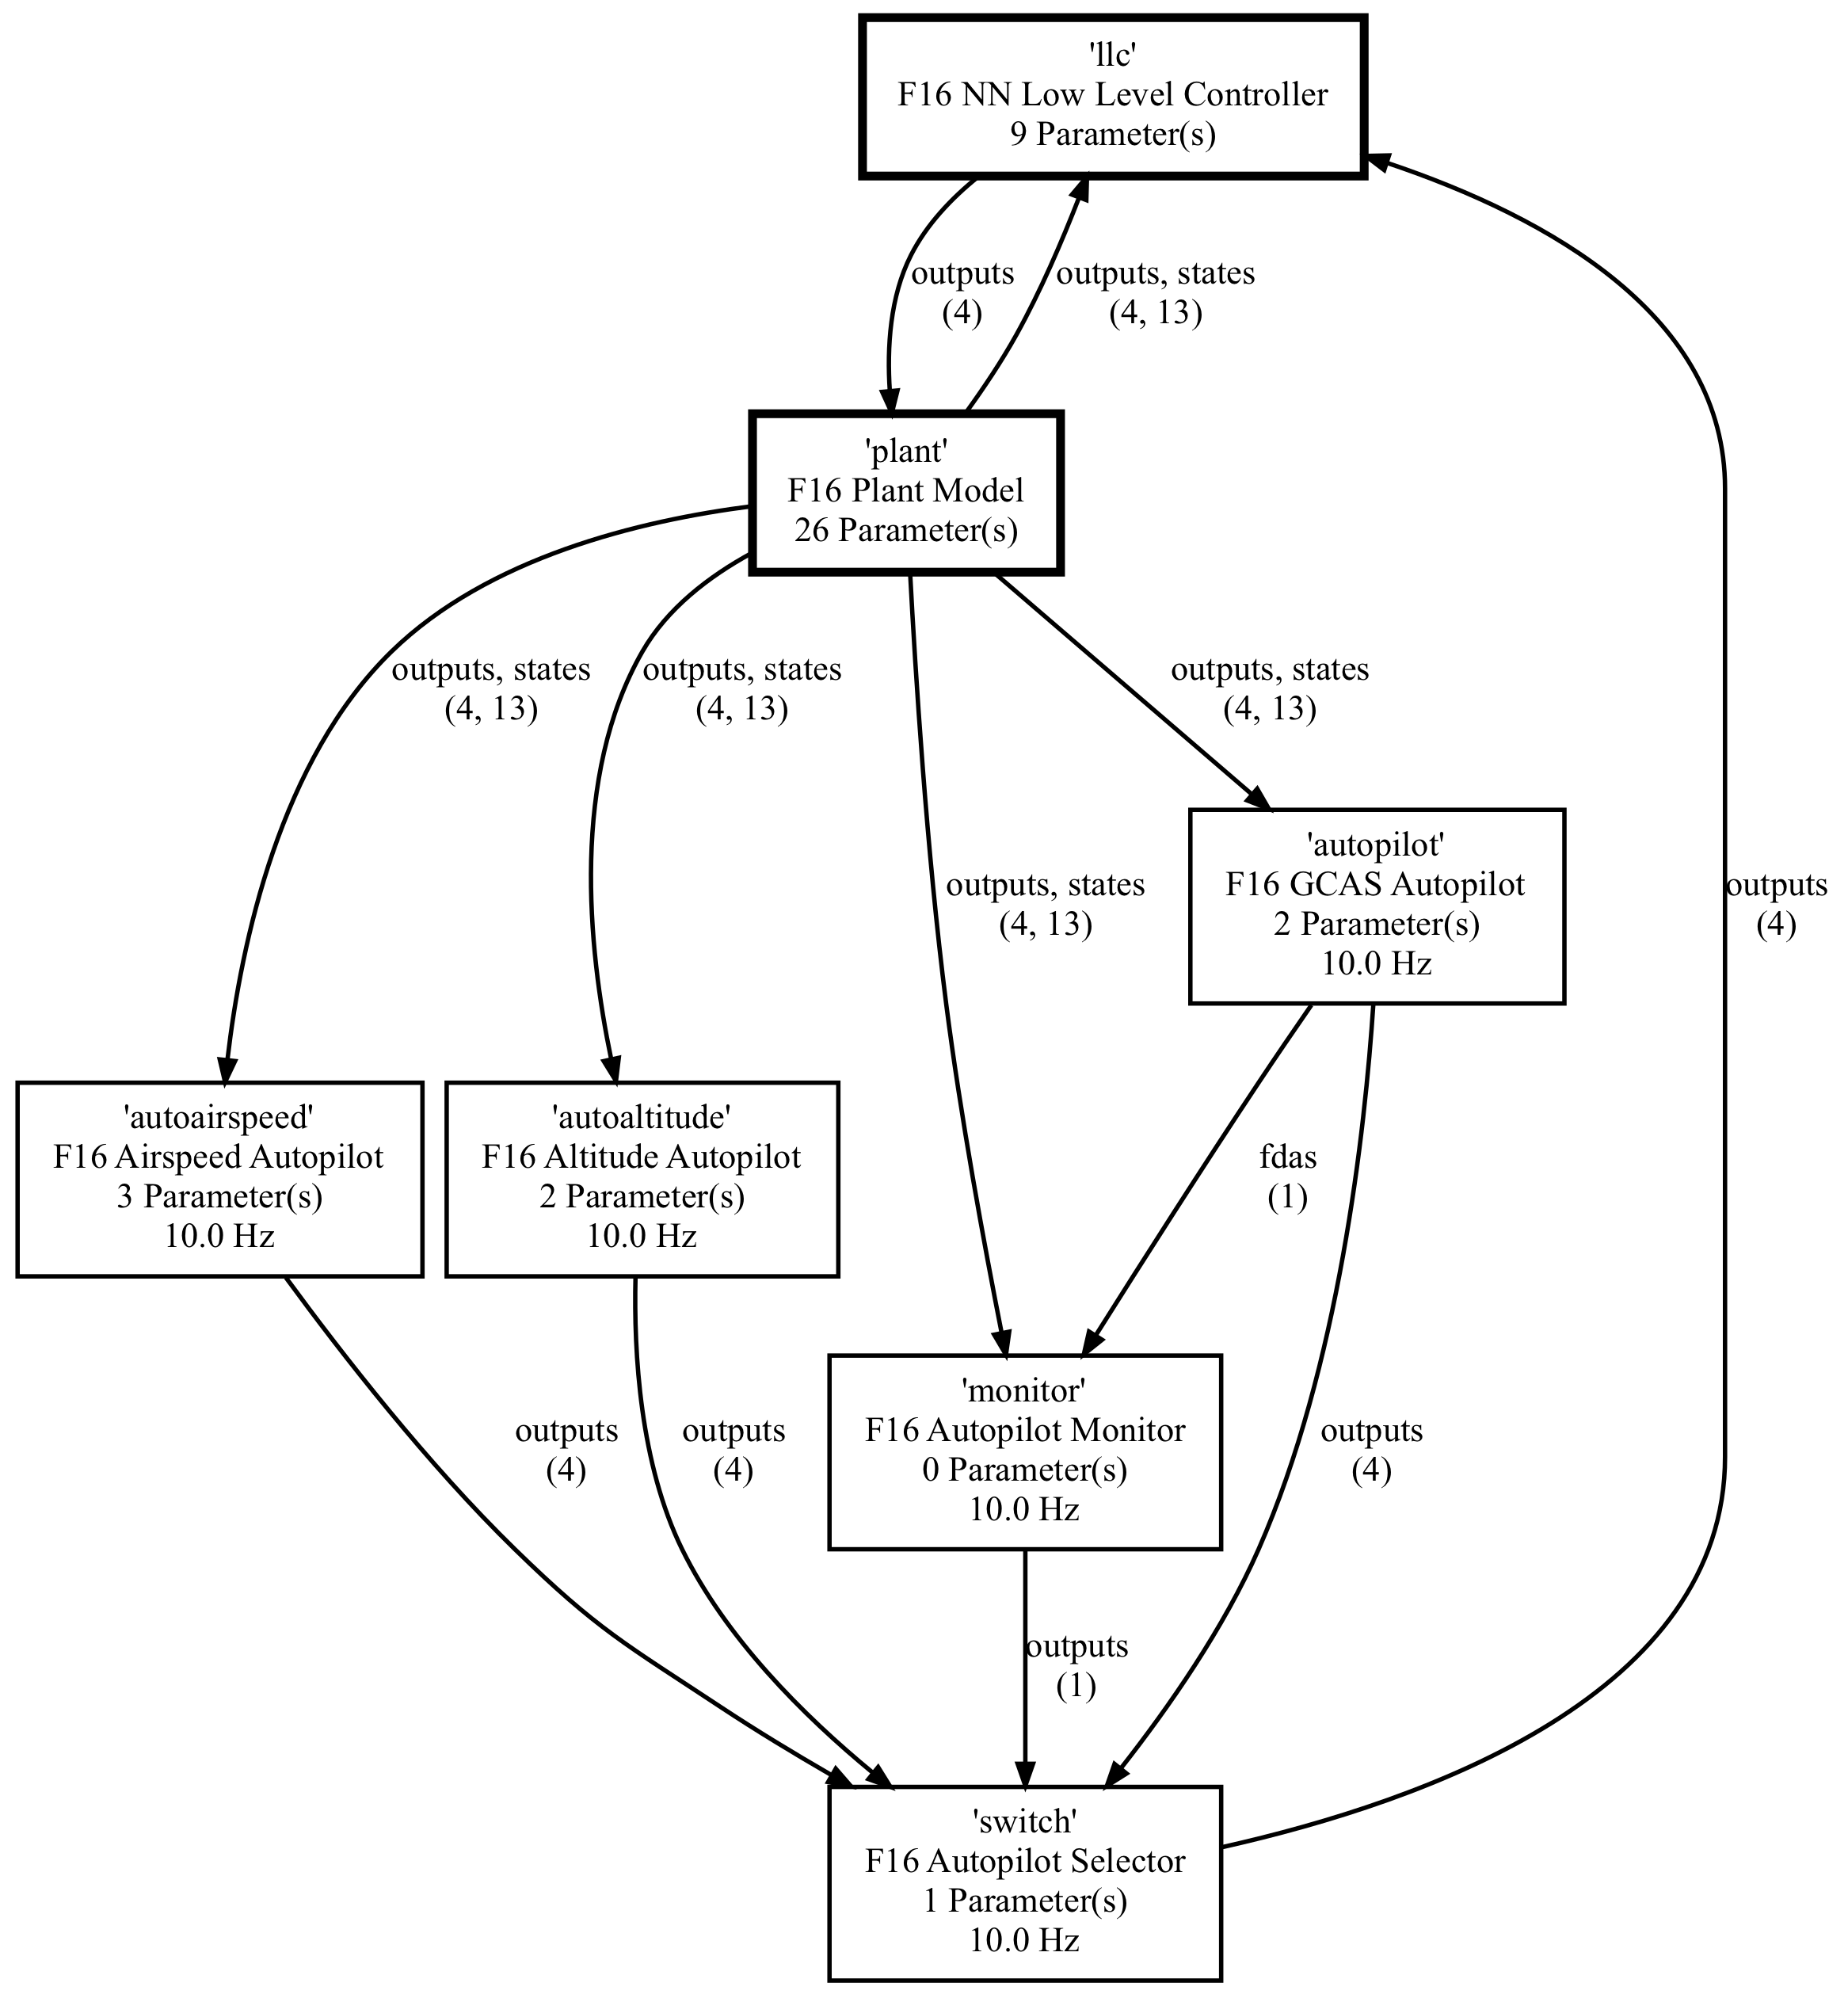

In [5]:
# check the system and see if it makes sense
F16Shield().check()

#display the system topology
csafutils.view_block_diagram(F16Shield, ipython_notebook=True)

## Simulating the system

In [6]:
# create system instance
my_system = F16Shield()

# put the f16 plant in a dive
f16_state = [ 
    540.0,
    0.037027160081059704,
    0.0,
    0.7853981633974483,
    -1.2566370614359172,
    -0.7853981633974483,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    3600.0,
    9.0]
my_system.set_state('plant', f16_state)

# timespan to simulate
simulation_timespan = [0, 35.0]

# simulate and collect time traces out of the components
trajs = my_system.simulate_tspan(simulation_timespan, show_status=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3850/3850 [00:01<00:00, 2611.29it/s]


## 2D Plot

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


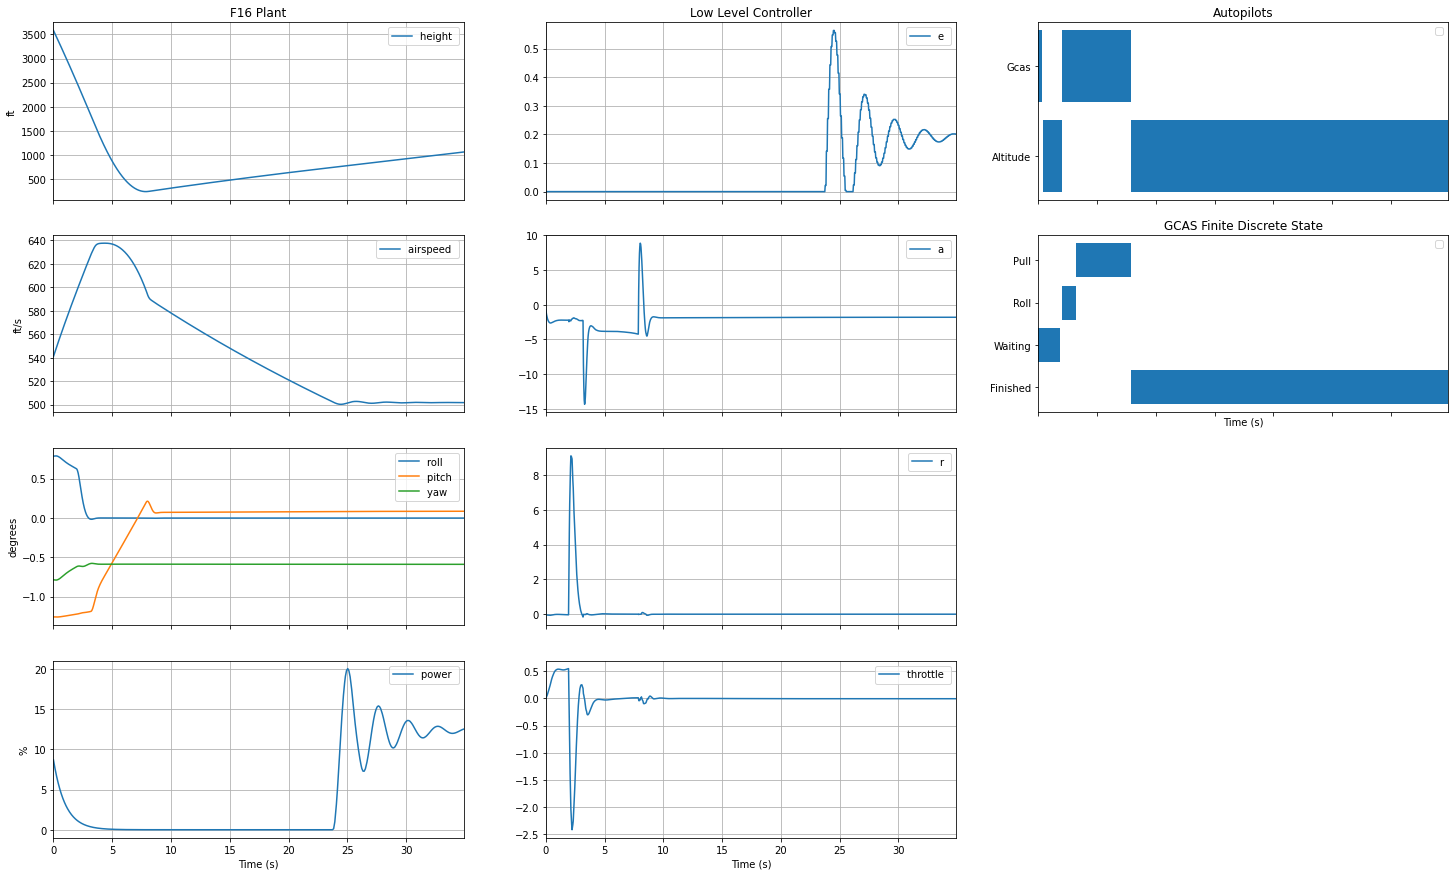

In [7]:
from csaf_f16.plot import plot_simple, plot_shield
import matplotlib.pyplot as plt

plot_shield(trajs)
plt.savefig("f16_gcas_plot.png")